SVHN Dataset Conversion
=====================

This code converts the Street View House Number dataset from its original Matlab format to WebDataset format (a simple tar file with separate records for images, bounding boxes, and transcript, all in text format).

The main difficulty is just decoding the Matlab v7.3 `.mat` file.

Dataset source:

http://ufldl.stanford.edu/housenumbers/

Download the original `.tar.gz` files, extract them, then run this notebook in the toplevel directory.

In [1]:
%pylab inline
import webdataset as wds
import scipy.io
import hdf5storage
import h5py
import simplejson
import os
import os.path

Populating the interactive namespace from numpy and matplotlib


Matlab v7.3 files are HDF5 files. The SVHN dump is in a rather messy format because it stores lots of "structures" and "objects", which get turned into HDF5 groups and references.

In [2]:
def deref(h5, x):
    if isinstance(x, h5py.h5r.Reference):
        return h5[x][0, 0]
    else:
        return x
    
def extract(h5, x, conv=int):
    data = [x[i, 0] for i in range(x.shape[0])]
    return [conv(deref(h5, r)) for r in data]

def get_info(h5, index):
    bbox = h5[h5["digitStruct"]["bbox"][index][0]]
    name = h5[h5["digitStruct"]["name"][index][0]]
    name = "".join([chr(name[i, 0]) for i in range(name.shape[0])])
    height = extract(h5, bbox["height"])
    width = extract(h5, bbox["width"])
    left = extract(h5, bbox["left"])
    top = extract(h5, bbox["top"])
    label = extract(h5, bbox["label"])
    bboxes = [dict(left=left[i], top=top[i], width=width[i], height=height[i], c=label[i]) for i in range(len(width))]
    return dict(fname=name, bboxes=bboxes)

def svhn_load(fname):
    h5 = h5py.File(fname)
    result = [get_info(h5, i) for i in range(len(h5["digitStruct"]["name"]))]
    return result

def svhn_info(fname):
    if os.path.exists(fname+".json"):
        print("loading", fname+".json", file=sys.stderr)
        with open(fname+".json", "r") as stream:
            return simplejson.load(stream)
    else:
        print("loading", fname, file=sys.stderr)
        result = svhn_load(fname)
        with open(fname+".json", "w") as stream:
            simplejson.dump(result, stream)
        return result
    
result = svhn_info("train/digitStruct.mat")
print(len(result))

loading train/digitStruct.mat.json


33402


In [3]:
result = svhn_info("extra/digitStruct.mat")
print(len(result))

loading extra/digitStruct.mat.json


202353


In [4]:
result = svhn_info("test/digitStruct.mat")
print(len(result))
result[0]

13068


loading test/digitStruct.mat.json


{'fname': '1.png',
 'bboxes': [{'left': 43, 'top': 7, 'width': 19, 'height': 30, 'c': 5}]}

In [5]:
from webdataset import writer
def readfile(fname):
    with open(fname, "rb") as stream:
        return stream.read()

In [6]:
def convert(dname):
    records = svhn_info(dname+"/digitStruct.mat")
    with writer.TarWriter(dname+".tar") as shard:
        for r in records:
            png = readfile(dname+"/"+r["fname"])
            json = r["bboxes"]
            txt = "".join([chr(ord("0")+b["c"]) for b in r["bboxes"]])
            __key__ = dname+"/"+re.sub("[.]png$", "", r["fname"])
            shard.write(dict(png=png, json=json, txt=txt, __key__=__key__))

In [7]:
convert("train")

loading train/digitStruct.mat.json


In [8]:
convert("test")

loading test/digitStruct.mat.json


In [9]:
convert("extra")

loading extra/digitStruct.mat.json


In [13]:
!tarshow -d 0 -c 5 train.tar

__key__             	train/1
__source__          	train.tar
json                	b'[{"left": 246, "top": 77, "width": 81, "height": 219, "c":
png                 	b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\xe5\x00\x0
txt                 	b'19'

__key__             	train/2
__source__          	train.tar
json                	b'[{"left": 77, "top": 29, "width": 23, "height": 32, "c": 2
png                 	b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xc7\x00\x0
txt                 	b'23'

__key__             	train/3
__source__          	train.tar
json                	b'[{"left": 17, "top": 5, "width": 8, "height": 15, "c": 2},
png                 	b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x004\x00\x00\x
txt                 	b'25'

__key__             	train/4
__source__          	train.tar
json                	b'[{"left": 57, "top": 13, "width": 15, "height": 34, "c": 9
png                 	b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xa1\x00\x0
txt                 

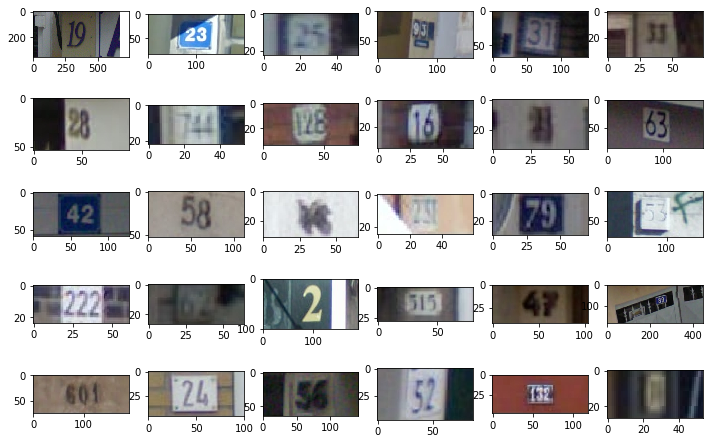

In [20]:
figsize(12, 8)
import webdataset as wds
for i, sample in enumerate(wds.WebDataset("train.tar")):
    if i==30: break
    subplot(5, 6, i+1)
    imshow(sample["png"])

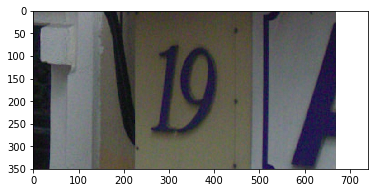